Optimal Rotation Age: 20.0 years


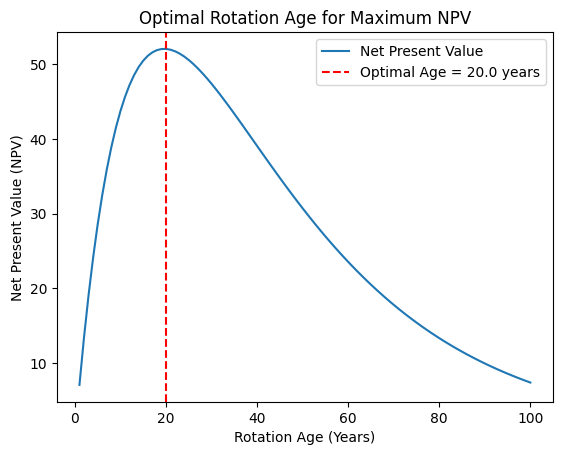

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def growth_function(age, max_height=30, growth_rate=0.05):
    return max_height * (1 - np.exp(-growth_rate * age))

def net_present_value(age, price_per_unit=10, cost_per_unit=5, discount_rate=0.03):
    timber_volume = growth_function(age)
    revenue = timber_volume * price_per_unit
    cost = timber_volume * cost_per_unit
    return (revenue - cost) * np.exp(-discount_rate * age)

ages = np.linspace(1, 100, 100)  # possible rotation ages from 1 to 100 years
npvs = [net_present_value(age) for age in ages]

optimal_age = ages[np.argmax(npvs)]
print(f"Optimal Rotation Age: {optimal_age} years")

# Plotting the NPV over time to visualize the optimal age
plt.plot(ages, npvs, label="Net Present Value")
plt.axvline(optimal_age, color="red", linestyle="--", label=f"Optimal Age = {optimal_age:.1f} years")
plt.xlabel("Rotation Age (Years)")
plt.ylabel("Net Present Value (NPV)")
plt.title("Optimal Rotation Age for Maximum NPV")
plt.legend()
plt.show()


In [16]:
import pandas as pd
import torch

# Set random seed for reproducibility
torch.manual_seed(0)

# Simulating a time-series dataset
time_steps = 100
time = torch.linspace(0, 10, time_steps)
initial_value = torch.tensor([0.0])

# Defining a simple ODE (e.g., exponential growth/decay)
def example_ode(t, y):
    return 0.5 * y  # This represents dy/dt = 0.5 * y

# Generate synthetic data points
y_values = [initial_value]
for t in time[1:]:
    y_values.append(y_values[-1] + example_ode(t, y_values[-1]) * (time[1] - time[0]))

# Convert to dataset format
data = pd.DataFrame({"time": time.numpy(), "value": torch.stack(y_values).numpy().flatten()})
data.head()


,time,value
0,0.00000,0.0
1,0.10101,0.0
2,0.20202,0.0
3,0.30303,0.0
4,0.40404,0.0


Epoch 0, Loss: 19.12543487548828


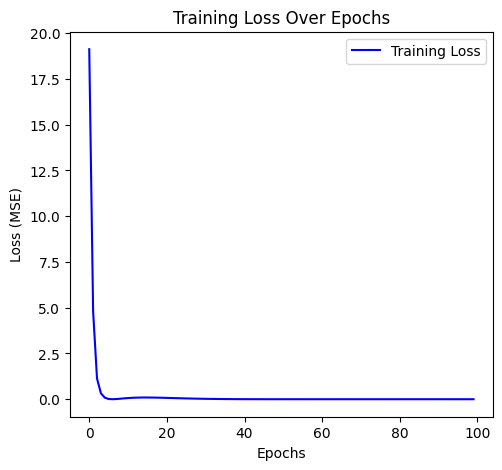

In [22]:
# Necessary imports
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
import matplotlib.pyplot as plt

# Define the Neural ODE Function
class ODEFunc(nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 50),
            nn.Tanh(),
            nn.Linear(50, 1)
        )

    def forward(self, t, y):
        return self.net(y)

class NeuralODE(nn.Module):
    def __init__(self, ode_func):
        super(NeuralODE, self).__init__()
        self.ode_func = ode_func

    def forward(self, y0, t):
        return odeint(self.ode_func, y0, t)

# Create synthetic dataset for training
torch.manual_seed(0)
time_steps = 100
time = torch.linspace(0, 10, time_steps)
initial_value = torch.tensor([[0.0]])

# Example ODE: dy/dt = 0.5 * y
def example_ode(t, y):
    return 0.5 * y

# Generate synthetic data based on example ODE
y_values = [initial_value]
for t in time[1:]:
    y_values.append(y_values[-1] + example_ode(t, y_values[-1]) * (time[1] - time[0]))

# Create dataset
data = torch.stack(y_values).flatten()

# Instantiate the model, optimizer, and loss function
ode_func = ODEFunc()
model = NeuralODE(ode_func)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

# Training loop
epochs = 100
losses = []

# Start training
for epoch in range(epochs):
    optimizer.zero_grad()
    predicted_y = model(initial_value, time)
    loss = criterion(predicted_y.flatten(), data)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    # Print loss occasionally
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

# Plot the training loss over epochs
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), losses, label="Training Loss", color="blue")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training Loss Over Epochs")
plt.legend()




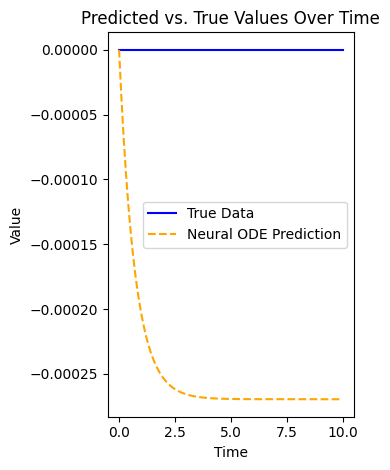

In [23]:
# Plot Predicted vs. True Values Over Time
plt.subplot(1, 2, 2)
plt.plot(time.numpy(), data.numpy(), label="True Data", color="blue")
plt.plot(time.numpy(), predicted_y.detach().numpy().flatten(), '--', label="Neural ODE Prediction", color="orange")
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Predicted vs. True Values Over Time")
plt.legend()

plt.tight_layout()
plt.show()

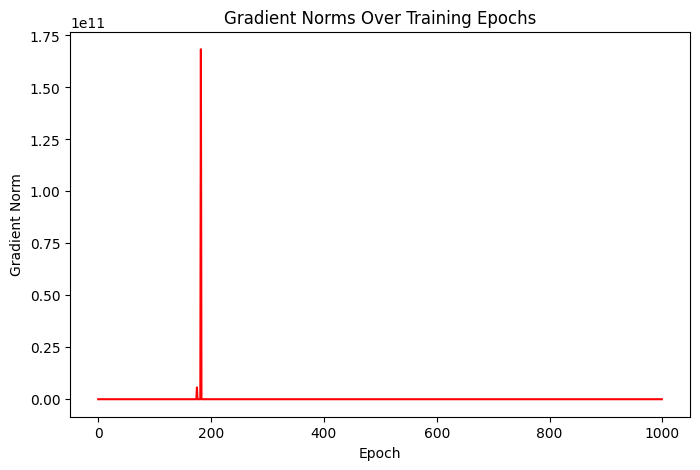

In [15]:
# Compute gradient norms for each epoch during training
gradient_norms = []

for epoch in range(epochs):
    optimizer.zero_grad()
    predicted_y = model(initial_value, time)
    loss = criterion(predicted_y.flatten(), data)
    loss.backward()

    # Calculate and store the norm of gradients
    total_norm = 0
    for p in model.parameters():
        param_norm = p.grad.data.norm(2)
        total_norm += param_norm.item() ** 2
    gradient_norms.append(total_norm ** 0.5)

    optimizer.step()

# Plot gradient norms over epochs
plt.figure(figsize=(8, 5))
plt.plot(range(epochs), gradient_norms, color="red")
plt.xlabel("Epoch")
plt.ylabel("Gradient Norm")
plt.title("Gradient Norms Over Training Epochs")
plt.show()
